In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA data

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator_ERAI(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
pmax_array = nc_open_compile(file_years,"pmax")
tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_rain_indx]

-56.0
56.0
(408655,)


In [4]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure.data)
print(plev_ERA)
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')[tropical_rain_indx]
# Extract the value around 550 hPa
omega_ERA_mid = omega_array[:,14]
# Extract the value around 200 hPa
omega_ERA_hi = omega_array[:,4]

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERA = negative_to_nan(cape_array)[tropical_rain_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERA = negative_to_nan(capepre_array)[tropical_rain_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERA = negative_to_nan(capepre6_array)[tropical_rain_indx]

# Filter for negative values of omega (ascent rates)
omega_ERA_mid_n, cape_ERA_n = negative_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_n, _ = negative_vals( omega_ERA_hi, cape_ERA )

_, capepre6_ERA_n = negative_vals( omega_ERA_mid, capepre6_ERA )
_, rad_ERA_n = negative_vals( omega_ERA_mid, rad_ERA )
_, ctt_ERA_n = negative_vals( omega_ERA_mid, ctt_ERA )
_, minctt_ERA_n = negative_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_n = negative_vals( omega_ERA_mid, lifetime_ERA )

_, rad_ERA_n2 = negative_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_n2 = negative_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_n2 = negative_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_n2 = negative_vals( omega_ERA_hi, lifetime_ERA )

[ 122.61370087  142.90170288  165.08859253  189.14660645  215.02510071
  242.65229797  272.05929565  303.21740723  336.04391479  370.40719604
  406.1328125   443.00860596  480.79071045  519.20928955  557.97338867
  596.77740479  635.30603027  673.24029541  710.26269531  746.06347656
  780.34552002  812.83032227  843.26342773  871.42028809  897.11181641
  920.18927002  940.55108643  958.14770508  972.98681641  985.13989258
  994.74719238 1002.02362061]


In [5]:
# Filter for positive values of omega (descent rates)
omega_ERA_mid_p, cape_ERA_p = positive_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_p, _ = positive_vals( omega_ERA_hi, cape_ERA )

_, capepre6_ERA_p = positive_vals( omega_ERA_mid, capepre6_ERA )
_, rad_ERA_p = positive_vals( omega_ERA_mid, rad_ERA )
_, ctt_ERA_p = positive_vals( omega_ERA_mid, ctt_ERA )
_, minctt_ERA_p = positive_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_p = positive_vals( omega_ERA_mid, lifetime_ERA )

_, rad_ERA_p2 = positive_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_p2 = positive_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_p2 = positive_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_p2 = positive_vals( omega_ERA_hi, lifetime_ERA )

In [6]:
nbins = 25
pc2 = 99
maxcape = 3700
cape_bins_ascent, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=20 ) 
capepre6_bins_ascent, ascent_vals2, _, ascent_99_vals2, cape_error_ascent2, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, capepre6_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=20 ) 

# create bins in CAPE and evaluate corresponding ascent rate percentiles stratifying for depth
upp = np.percentile( minctt_ERA_n, 75 )
loo = np.percentile( minctt_ERA_n, 25 )
cape_bins_deep, ascent_vals_deep, _, ascent_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[minctt_ERA_n <= loo], omega_ERA_mid_n[minctt_ERA_n <= loo], pc2=pc2, threshold=20 )
cape_bins_shallow, ascent_vals_shallow, _, ascent_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[minctt_ERA_n >= upp], omega_ERA_mid_n[minctt_ERA_n >= upp], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles stratifying for lifetime
upp = np.percentile( lifetime_ERA_n, 75 )
loo = np.percentile( lifetime_ERA_n, 25 )
cape_bins_old, ascent_vals_old, _, ascent_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[lifetime_ERA_n >= upp], omega_ERA_mid_n[lifetime_ERA_n >= upp], pc2=pc2, threshold=20 )
cape_bins_young, ascent_vals_young, _, ascent_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[lifetime_ERA_n <= loo], omega_ERA_mid_n[lifetime_ERA_n <= loo], pc2=pc2, threshold=20 )

### Look at the scaling of ascent rates against CAPE across different morphologies

In [7]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

0.003316569071745798 0.8166847494031001 1.9800466945886468e-08
0.003525225784322491 0.8175345336522923 2.6366115654055263e-07
0.0025323343209577823 0.6555622387520784 4.674481861448855e-05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.02347480854730442 0.3716279249157209 0.0033476119372024588
0.03798983106748768 0.4408536159706428 0.002656577205857649
0.0166794025132616 0.236689403072796 0.0560107109540408


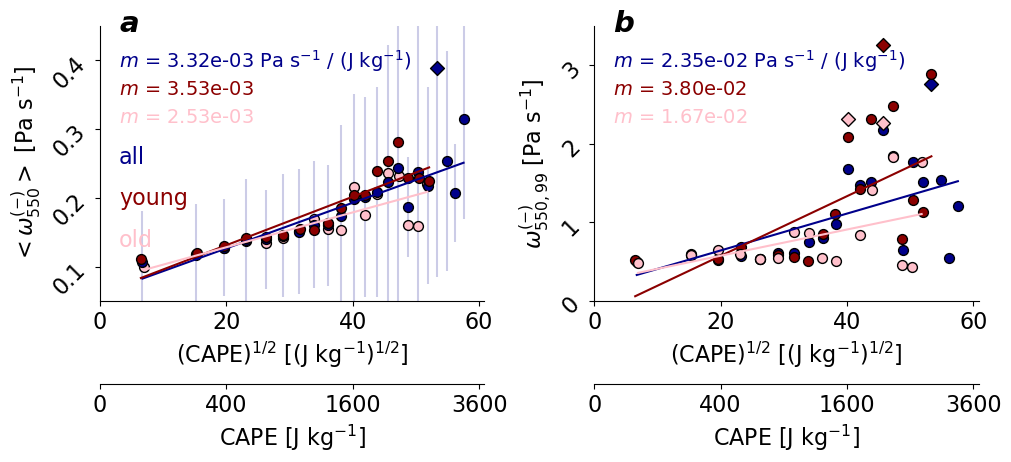

In [9]:
fig, ax = plt.subplots( 1, 2, figsize =(10, 4.5), constrained_layout=True )
sz = 50
lw = 1.5

ylab = [ r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', '$\omega_{550, 99}^{(-)}$ [Pa s$^{-1}$]' ]
labels = [ r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ 'a', 'b' ]
font_size = 16
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xticks( [0, np.sqrt(400), np.sqrt(1600), np.sqrt(3600)] )
    axis.set_xlim( [0, np.sqrt(maxcape)] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.98, let[i], transform=axis.transAxes, style='italic', fontsize=font_size+5, weight='bold' )
        
    if i == 0:
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_ascent, ascent_vals, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkblue', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw  )
        axis.text( 0.05, 0.85, r"$m$ = " + f"{out.slope:.2e}" + r" Pa s$^{-1}$ / (J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_young), ascent_vals_young )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_young, ascent_vals_young, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkred', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkred', linewidth=lw )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}", color='darkred',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
    
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_old), ascent_vals_old )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_old, ascent_vals_old, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='pink', edgecolor='black', zorder=-1, marker=m )
        axis.plot( x_input, y_predicted, color='pink', linewidth=lw )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='pink',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)

        axis.text( 0.05, 0.5, 'all', color='darkblue', fontsize=font_size, transform=axis.transAxes )
        axis.text( 0.05, 0.35, 'young', color='darkred', fontsize=font_size, transform=axis.transAxes )
        axis.text( 0.05, 0.2, 'old', color='pink', fontsize=font_size, transform=axis.transAxes )
        axis.set_ylim([0.05, 0.45])
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
    elif i == 1:
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_ascent, ascent_99_vals, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkblue', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw )
        axis.text( 0.05, 0.85, r"$m$ = " + f"{out.slope:.2e}" + r" Pa s$^{-1}$ / (J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_young), ascent_99_vals_young )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_young, ascent_99_vals_young, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkred', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkred', linewidth=lw )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}", color='darkred',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_old), ascent_99_vals_old )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_old, ascent_99_vals_old, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='pink', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='pink', linewidth=lw )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='pink',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.set_ylim([0, 3.5])
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )     

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERA-lifetime.pdf', bbox_inches='tight' )
plt.show() 